In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = '/kaggle/input/anerbc-2-gan-seg/AneRBC_II_combine/'

In [3]:
BUFFER_SIZE = 2
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

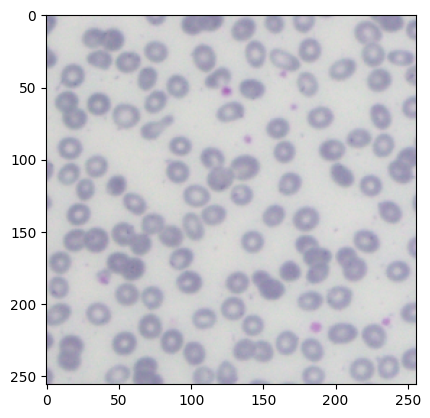

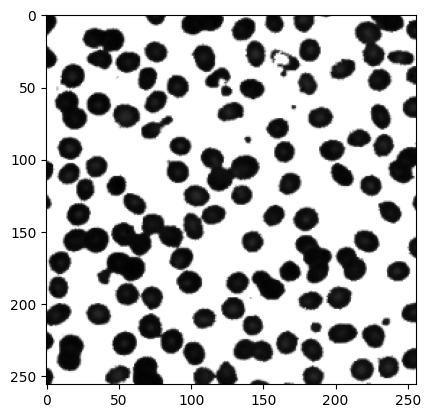

In [6]:
inp, re = load(PATH+'train/0001_01_a.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

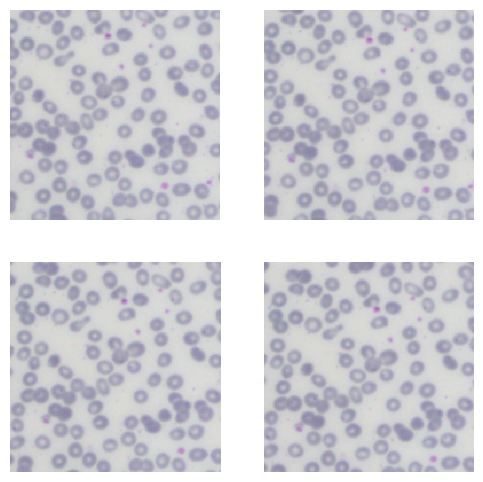

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [16]:
OUTPUT_CHANNELS = 3

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [21]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

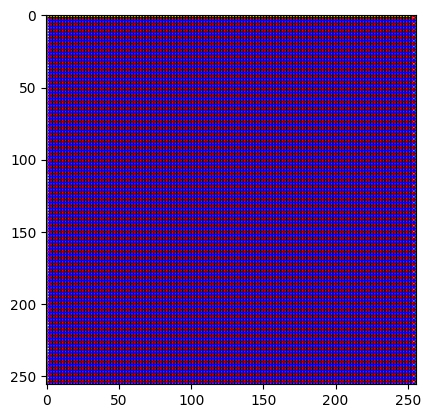

In [23]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [24]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [25]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

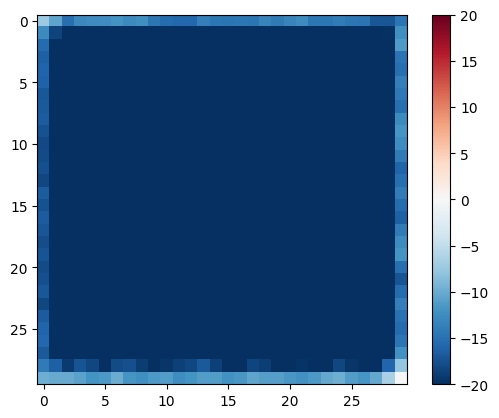

In [27]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [28]:
# ... [Your previous code remains unchanged up to the definition of the train_step function]
# Define the loss object
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Define additional metrics and loss functions
def dice_coef(y_true, y_pred):
    smooth = 1e-10
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + 1e-5)

def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-5)

def specificity(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    possible_negatives = tf.reduce_sum(1 - y_true)
    return true_negatives / possible_negatives
def accuracy(y_true, y_pred):
    y_true = tf.round(tf.sigmoid(y_true))
    y_pred = tf.round(tf.sigmoid(y_pred))
    correct_pixels = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pixels, tf.float32))
    return accuracy


# 2. Modify the Training Loop and 3. Store the Metrics
train_metrics = {
    'gen_total_loss': [],
    'gen_gan_loss': [],
    'gen_l1_loss': [],
    'disc_loss': [],
    'dice_coef': [],
    'iou': [],
    'precision': [],
    'recall': [],
    'specificity': []
}

val_metrics = {
    'val_gen_total_loss': [],
    'val_gen_gan_loss': [],
    'val_gen_l1_loss': [],
    'val_disc_loss': [],
    'val_dice_coef': [],
    'val_iou': [],
    'val_precision': [],
    'val_recall': [],
    'val_specificity': []
}

# 4. Modify the train_step Function
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # ... [rest of the train_step function remains unchanged]

    # Calculate metrics
    dice = dice_coef(target, gen_output)
    iou_val = iou(target, gen_output)
    prec = precision(target, gen_output)
    rec = recall(target, gen_output)
    spec = specificity(target, gen_output)

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec

# 5. Validation Loop
def validate_step(input_image, target):
    gen_output = generator(input_image, training=False)
    disc_real_output = discriminator([input_image, target], training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate metrics
    dice = dice_coef(target, gen_output)
    iou_val = iou(target, gen_output)
    prec = precision(target, gen_output)
    rec = recall(target, gen_output)
    spec = specificity(target, gen_output)

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec

# Update the fit function to include validation and store metrics
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        # ... [rest of the fit function remains unchanged]

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice, iou_val, prec, rec, spec = train_step(input_image, target)
            # Store metrics
            train_metrics['gen_total_loss'].append(gen_total_loss)
            train_metrics['gen_gan_loss'].append(gen_gan_loss)
            train_metrics['gen_l1_loss'].append(gen_l1_loss)
            train_metrics['disc_loss'].append(disc_loss)
            train_metrics['dice_coef'].append(dice)
            train_metrics['iou'].append(iou_val)
            train_metrics['precision'].append(prec)
            train_metrics['recall'].append(rec)
            train_metrics['specificity'].append(spec)

        # Validate
        for n, (input_image, target) in test_ds.enumerate():
            val_gen_total_loss, val_gen_gan_loss, val_gen_l1_loss, val_disc_loss, val_dice, val_iou_val, val_prec, val_rec, val_spec = validate_step(input_image, target)
            # Store metrics
            val_metrics['val_gen_total_loss'].append(val_gen_total_loss)
            val_metrics['val_gen_gan_loss'].append(val_gen_gan_loss)
            val_metrics['val_gen_l1_loss'].append(val_gen_l1_loss)
            val_metrics['val_disc_loss'].append(val_disc_loss)
            val_metrics['val_dice_coef'].append(val_dice)
            val_metrics['val_iou'].append(val_iou_val)
            val_metrics['val_precision'].append(val_prec)
            val_metrics['val_recall'].append(val_rec)
            val_metrics['val_specificity'].append(val_spec)

# ... [rest of your code remains unchanged]


In [29]:
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
# def discriminator_loss(disc_real_output, disc_generated_output):
#   real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#   generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#   total_disc_loss = real_loss + generated_loss

#   return total_disc_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
!mkdir 'results'
#indx = 0;
def generate_images(model, test_input, tar,indx=0):
  prediction = model(test_input, training=True)
  fig = plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  #print(tar)

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  fig.savefig('results/' + str(indx) + '.png')
# Initialize a list to store displayed images
# persistent_display_list = []

# def generate_images(model, test_input, tar, ep=0):
#   prediction = model(test_input, training=True)
#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   # Add the current display list to the persistent list
#   persistent_display_list.append(display_list)

#   if ep % 5 == 0:
#     # Display all images in the persistent display list
#     for display_list in persistent_display_list:
#       plt.figure(figsize=(15, 15))
#       for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(title[i])
#         # Getting the pixel values between [0, 1] to plot it.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
#       plt.show()

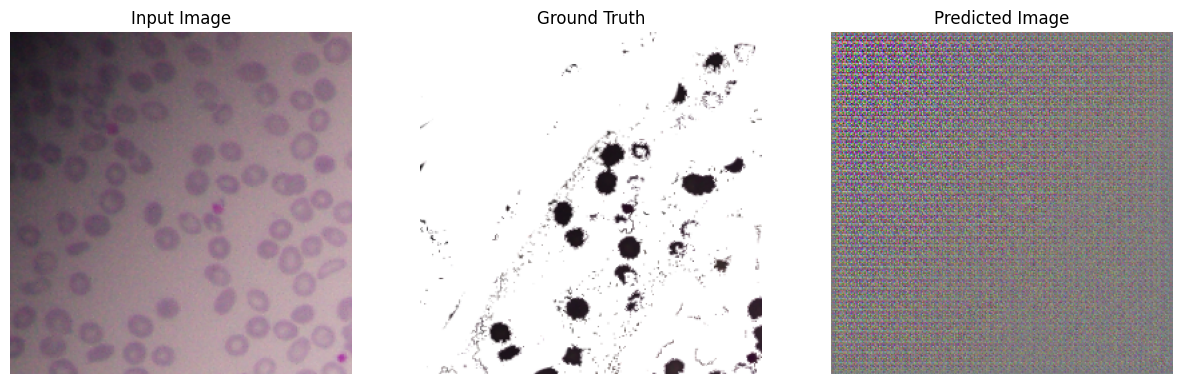

In [34]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [35]:
EPOCHS = 200

In [36]:
import datetime
log_dir=log_dir="/kaggle/working/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [38]:
import tensorflow as tf
import time
from IPython import display

@tf.function
def train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        dice_coef_value = dice_coef(target, gen_output)
        iou_value = iou(target, gen_output)
        precision_value = precision(target, gen_output)
        recall_value = recall(target, gen_output)
        specificity_value = specificity(target, gen_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value


In [39]:
@tf.function
def test_step(input_image, target, generator, discriminator, loss_object, accuracy):
    gen_output = generator(input_image, training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)
    
    val_loss = loss_object(target, gen_output)
    val_accuracy = accuracy(target, gen_output)
    val_dice_coef = dice_coef(target, gen_output)
    val_iou = iou(target, gen_output)
    val_precision = precision(target, gen_output)
    val_recall = recall(target, gen_output)
    val_specificity = specificity(target, gen_output)

    return val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity


In [40]:
# def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, generate_images, checkpoint, checkpoint_prefix):
#     for epoch in range(epochs):
#         start = time.time()

#         display.clear_output(wait=True)

#         for example_input, example_target in test_ds.take(1):
#             generate_images(generator, example_input, example_target)
#         print("Epoch: ", epoch)

#         for n, (input_image, target) in train_ds.enumerate():
#             gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
#             print(f"Training - Loss: {gen_total_loss:.4f}, GAN Loss: {gen_gan_loss:.4f}, L1 Loss: {gen_l1_loss:.4f}, Dice Coef: {dice_coef_value:.4f}, IOU: {iou_value:.4f}, Precision: {precision_value:.4f}, Recall: {recall_value:.4f}, Specificity: {specificity_value:.4f}")

#         for input_image, target in test_ds:
#             val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
        
#         print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Dice Coef: {val_dice_coef:.4f}, IOU: {val_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, Specificity: {val_specificity:.4f}")

#         if (epoch + 1) % 100 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

#         print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
#     checkpoint.save(file_prefix = checkpoint_prefix)

# def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, generate_images, checkpoint, checkpoint_prefix):
#     for epoch in range(epochs):
#         start = time.time()

#         # Initialize accumulators
#         total_gen_loss, total_gen_gan_loss, total_gen_l1_loss, total_disc_loss = 0, 0, 0, 0
#         total_dice_coef, total_iou, total_precision, total_recall, total_specificity = 0, 0, 0, 0, 0
#         num_batches = 0

#         display.clear_output(wait=True)

#         for example_input, example_target in test_ds.take(1):
#             generate_images(generator, example_input, example_target)
#         print("Epoch: ", epoch)

#         for n, (input_image, target) in train_ds.enumerate():
#             gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            
#             # Update accumulators
#             total_gen_loss += gen_total_loss
#             total_gen_gan_loss += gen_gan_loss
#             total_gen_l1_loss += gen_l1_loss
#             total_disc_loss += disc_loss
#             total_dice_coef += dice_coef_value
#             total_iou += iou_value
#             total_precision += precision_value
#             total_recall += recall_value
#             total_specificity += specificity_value
#             num_batches += 1

#         # Print average values for training
#         print(f"Training - Avg Loss: {total_gen_loss/num_batches:.4f}, Avg GAN Loss: {total_gen_gan_loss/num_batches:.4f}, Avg L1 Loss: {total_gen_l1_loss/num_batches:.4f}, Avg Dice Coef: {total_dice_coef/num_batches:.4f}, Avg IOU: {total_iou/num_batches:.4f}, Avg Precision: {total_precision/num_batches:.4f}, Avg Recall: {total_recall/num_batches:.4f}, Avg Specificity: {total_specificity/num_batches:.4f}")

#         # Reset accumulators for validation
#         total_val_loss, total_val_accuracy, total_val_dice_coef, total_val_iou, total_val_precision, total_val_recall, total_val_specificity = 0, 0, 0, 0, 0, 0, 0
#         num_val_batches = 0

#         for input_image, target in test_ds:
#             val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
            
#             # Update accumulators for validation
#             total_val_loss += val_loss
#             total_val_accuracy += val_accuracy
#             total_val_dice_coef += val_dice_coef
#             total_val_iou += val_iou
#             total_val_precision += val_precision
#             total_val_recall += val_recall
#             total_val_specificity += val_specificity
#             num_val_batches += 1

#         # Print average values for validation
#         print(f"Validation - Avg Loss: {total_val_loss/num_val_batches:.4f}, Avg Accuracy: {total_val_accuracy/num_val_batches:.4f}, Avg Dice Coef: {total_val_dice_coef/num_val_batches:.4f}, Avg IOU: {total_val_iou/num_val_batches:.4f}, Avg Precision: {total_val_precision/num_val_batches:.4f}, Avg Recall: {total_val_recall/num_val_batches:.4f}, Avg Specificity: {total_val_specificity/num_val_batches:.4f}")

#         if (epoch + 1) % 100 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

#         print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
#     checkpoint.save(file_prefix = checkpoint_prefix)


In [ ]:
def fit(train_ds, epochs, test_ds, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object, accuracy, checkpoint, checkpoint_prefix):
    for epoch in range(epochs):
        start = time.time()

        # Initialize accumulators
        total_gen_loss, total_gen_gan_loss, total_gen_l1_loss, total_disc_loss = 0, 0, 0, 0
        total_dice_coef, total_iou, total_precision, total_recall, total_specificity = 0, 0, 0, 0, 0
        num_batches = 0

        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, dice_coef_value, iou_value, precision_value, recall_value, specificity_value = train_step(input_image, target, epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            
            # Update accumulators
            total_gen_loss += gen_total_loss
            total_gen_gan_loss += gen_gan_loss
            total_gen_l1_loss += gen_l1_loss
            total_disc_loss += disc_loss
            total_dice_coef += dice_coef_value
            total_iou += iou_value
            total_precision += precision_value
            total_recall += recall_value
            total_specificity += specificity_value
            num_batches += 1

        # Print average values for training
        print(f"Training - Avg Loss: {total_gen_loss/num_batches:.4f}, Avg GAN Loss: {total_gen_gan_loss/num_batches:.4f}, Avg L1 Loss: {total_gen_l1_loss/num_batches:.4f}, Avg Dice Coef: {total_dice_coef/num_batches:.4f}, Avg IOU: {total_iou/num_batches:.4f}, Avg Precision: {total_precision/num_batches:.4f}, Avg Recall: {total_recall/num_batches:.4f}, Avg Specificity: {total_specificity/num_batches:.4f}")

        # Reset accumulators for validation
        total_val_loss, total_val_accuracy, total_val_dice_coef, total_val_iou, total_val_precision, total_val_recall, total_val_specificity = 0, 0, 0, 0, 0, 0, 0
        num_val_batches = 0

        for input_image, target in test_ds:
            val_loss, val_accuracy, val_dice_coef, val_iou, val_precision, val_recall, val_specificity = test_step(input_image, target, generator, discriminator, loss_object, accuracy)
            
            # Update accumulators for validation
            total_val_loss += val_loss
            total_val_accuracy += val_accuracy
            total_val_dice_coef += val_dice_coef
            total_val_iou += val_iou
            total_val_precision += val_precision
            total_val_recall += val_recall
            total_val_specificity += val_specificity
            num_val_batches += 1

        # Print average values for validation
        print(f"Validation - Avg Loss: {total_val_loss/num_val_batches:.4f}, Avg Accuracy: {total_val_accuracy/num_val_batches:.4f}, Avg Dice Coef: {total_val_dice_coef/num_val_batches:.4f}, Avg IOU: {total_val_iou/num_val_batches:.4f}, Avg Precision: {total_val_precision/num_val_batches:.4f}, Avg Recall: {total_val_recall/num_val_batches:.4f}, Avg Specificity: {total_val_specificity/num_val_batches:.4f}")

        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

    checkpoint.save(file_prefix = checkpoint_prefix)

history = fit(
    train_dataset, 
    EPOCHS, 
    test_dataset, 
    generator, 
    discriminator, 
    generator_optimizer, 
    discriminator_optimizer, 
    loss_object, 
    accuracy,  
    checkpoint, 
    checkpoint_prefix
)


Epoch:  0


2023-10-31 18:05:14.910143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [80]:
# def fit(train_ds, epochs, test_ds):
#   for epoch in range(epochs):
#     start = time.time()

#     display.clear_output(wait=True)

#     for example_input, example_target in test_ds.take(1):
#       generate_images(generator, example_input, example_target)
#     print("Epoch: ", epoch)

#     # Train
#     for n, (input_image, target) in train_ds.enumerate():
#       print('.', end='')
#       if (n+1) % 100 == 0:
#         print()
#       train_step(input_image, target, epoch)
#     print()
#     # saving (checkpoint) the model every 20 epochs
#     if (epoch + 1) % 100 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                         time.time()-start))
#   checkpoint.save(file_prefix = checkpoint_prefix)

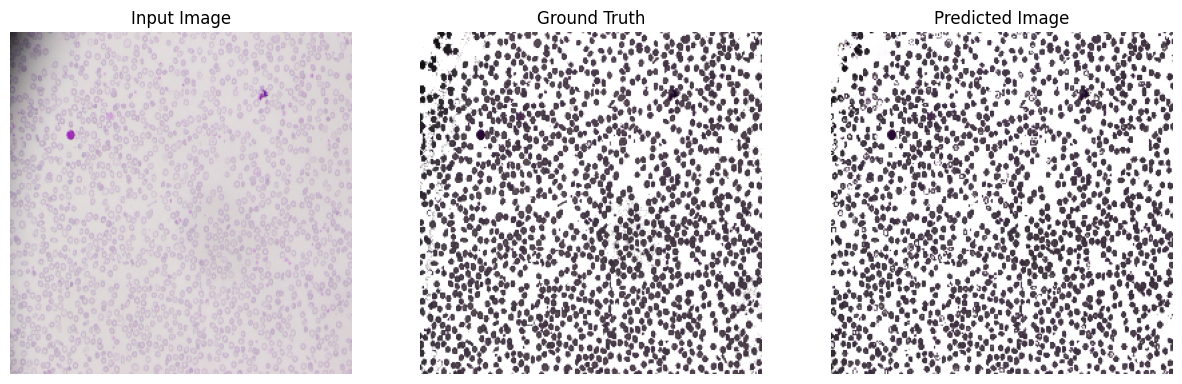

Epoch:  13


2023-10-26 11:40:53.003934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


KeyboardInterrupt: 

In [81]:

history = fit(
    train_dataset, 
    EPOCHS, 
    test_dataset, 
    generator, 
    discriminator, 
    generator_optimizer, 
    discriminator_optimizer, 
    loss_object, 
    accuracy,  # This is the accuracy function you've defined
    generate_images,  # You need to define this function or provide its definition if it's already defined
    checkpoint, 
    checkpoint_prefix
)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
#!tensorboard dev upload --logdir  {log_dir}
#!tensorboard dev upload --logdir {log_dir}
!echo "yes" | tensorboard dev upload --logdir {log_dir}

In [ ]:
display.IFrame(
   src="https://tensorboard.dev/experiment/VY2qtEYZSLO2AiLPmVcMoQ/",
   width="100%",
   height="1000px")

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test dataset
i = 1;
for inp, tar in test_dataset.take(99):
  generate_images(generator, inp, tar,i)
  i=i+1
!zip -r results.zip results